In [52]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

In [53]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [54]:
def convert_to_numpy(dataloader, limit=10000):
    data, labels = [], []
    for images, lbls in dataloader:
        data.append(images.view(images.size(0), -1).numpy())
        labels.append(lbls.numpy())
        if len(data) * dataloader.batch_size >= limit:
            break
    data = np.concatenate(data)[:limit]
    labels = np.concatenate(labels)[:limit]
    return data, labels

X_train_full, y_train_full = convert_to_numpy(trainloader)
X_test, y_test = convert_to_numpy(testloader)

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=1234)

In [56]:
k_values = [1, 5, 10, 50]
k_to_accuracies = {}

# 5-fold
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracies = cross_val_score(knn, X_train, y_train, cv=5)
    k_to_accuracies[k] = accuracies
    for accuracy in accuracies:
        print(f"k = {k}, accuracy = {accuracy:.4f}")

k = 1, accuracy = 0.2762
k = 1, accuracy = 0.2744
k = 1, accuracy = 0.2800
k = 1, accuracy = 0.2750
k = 1, accuracy = 0.2731
k = 5, accuracy = 0.2800
k = 5, accuracy = 0.2681
k = 5, accuracy = 0.2850
k = 5, accuracy = 0.2875
k = 5, accuracy = 0.2894
k = 10, accuracy = 0.2913
k = 10, accuracy = 0.2787
k = 10, accuracy = 0.2794
k = 10, accuracy = 0.2988
k = 10, accuracy = 0.2787
k = 50, accuracy = 0.2831
k = 50, accuracy = 0.2656
k = 50, accuracy = 0.2600
k = 50, accuracy = 0.2787
k = 50, accuracy = 0.2581


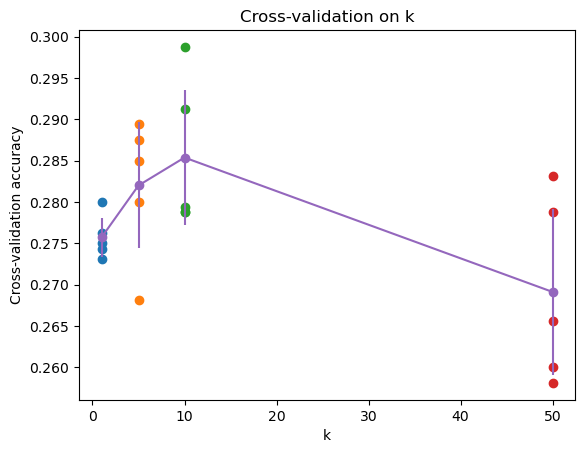

In [57]:
for k in k_values:
    accuracies = k_to_accuracies[k]
    plt.plot([k] * len(accuracies), accuracies, 'o')

accuracies_mean = np.array([np.mean(v) for k, v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k, v in sorted(k_to_accuracies.items())])
plt.errorbar(k_values, accuracies_mean, yerr=accuracies_std, fmt='-o')
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [58]:
best_k = k_values[np.argmax(accuracies_mean)]
print(f"Best k based on cross-validation: {best_k}")

Best k based on cross-validation: 10


In [59]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

train_acc = accuracy_score(y_train, knn.predict(X_train))
val_acc = accuracy_score(y_val, knn.predict(X_val))
test_acc = accuracy_score(y_test, knn.predict(X_test))

print(f"Best k: {best_k}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}")

Best k: 10, Train Accuracy: 0.3870, Validation Accuracy: 0.2900, Test Accuracy: 0.2933


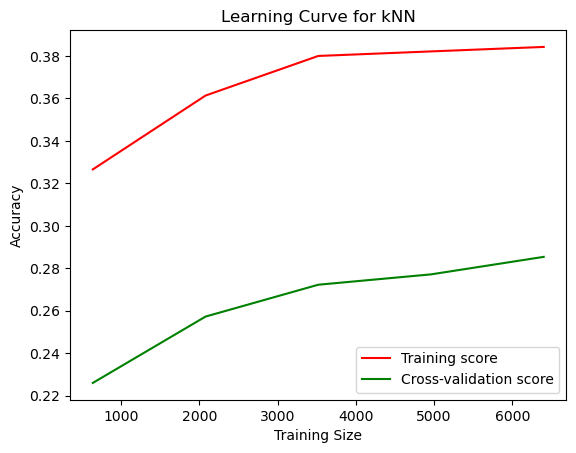

In [60]:
train_sizes, train_scores, val_scores = learning_curve(
    KNeighborsClassifier(n_neighbors=best_k), X_train, y_train, cv=5, 
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, color='r', label='Training score')
plt.plot(train_sizes, val_scores_mean, color='g', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for kNN')
plt.legend()
plt.show()

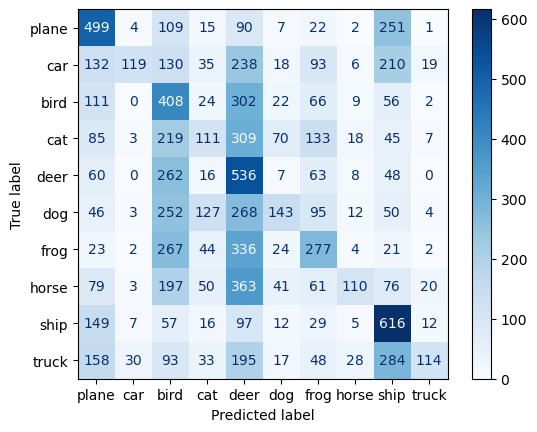

In [61]:
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=range(10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [62]:
start_time = time.time()
predictions = knn.predict(X_test)
end_time = time.time()

prediction_time = end_time - start_time
time_per_image = prediction_time / len(X_test)
print(f"Average prediction time per image: {time_per_image:.6f} seconds")

Average prediction time per image: 0.000190 seconds
